In [1]:
using Distributions
using ForwardDiff
using LinearAlgebra
using Optim
using Plots
using Random
using StateSpaceDynamics

In [2]:
Random.seed!(12345)
g = 9.81
l=1
# time differential
dt = 0.01
# transition matrix
A = Matrix{Float64}([1.0 dt; -g/l*dt 1.0])
# Initial state
x0 = [0.0, 1.0]
# Define the LDS model parameters
C = Matrix{Float64}(I(2))  # Observation matrix (assuming direct observation)
Q = Matrix{Float64}(0.01 * I(2))  # Process noise covariance
observation_noise_std = 0.5
R = Matrix{Float64}((observation_noise_std^2) * I(2))  # Observation noise covariance
P0 = Matrix{Float64}(0.1*I(2))  # Initial state covariance

lds = StateSpaceDynamics.GaussianLDS(;A=A, C=C, Q=Q, R=R, x0=x0, P0=P0, obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true])

x, y = StateSpaceDynamics.sample(lds, 300, 1)

([0.6642959648558582 0.6277693712854482 … -0.6722694737641656 -0.683621141304855;;; 0.7796139000201366 0.7554760746277481 … -0.9449793290258123 -0.9700682069840066], [0.34118411184885694 1.195435774591687 … -0.553800870574252 -1.198221132575609;;; 0.7010350966592787 1.0966343444892424 … -1.4215666229648622 -0.9040233649451017])

In [3]:
x, p_smooth, inverse_offdiag = StateSpaceDynamics.smooth(lds, y)

entropy_calc_1 = sum(StateSpaceDynamics.gaussianentropy(Matrix(p_smooth[1, t, :, :])) for t in axes(p_smooth, 2))

H, main, super, sub = StateSpaceDynamics.Hessian(lds, y[1, :, :])

entropy_calc_2 = 0.5 * (300 * 2 * log(2 * π * ℯ) - logdet(Matrix(H)))

-589.6194415093252

In [3]:
lds_new = StateSpaceDynamics.GaussianLDS(;obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true])
lls, norms = StateSpaceDynamics.fit!(lds, y; max_iter=1000)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:38


([-1484.230826032236, -1464.6329439686615, -1461.5853711278878, -1460.2492098012183, -1459.2135196666036, -1458.280555578916, -1457.4136177832784, -1456.6009728532176, -1455.836204249333, -1455.1147315193812  …  -1437.5369668074059, -1437.5369603299075, -1437.5369538764198, -1437.5369474467275, -1437.5369410407448, -1437.5369346582977, -1437.5369282992483, -1437.5369219634833, -1437.5369156508345, -1437.5369093611434], [0.10238940263166192, 0.017994695441097972, 0.008209707053886612, 0.005252625984525939, 0.004041442281018304, 0.003438363925676144, 0.003077264897641367, 0.00282328229483004, 0.002622284957427519, 0.002450821898027301  …  2.400712465363822e-7, 2.397620846414161e-7, 2.394545035458607e-7, 2.391484679277833e-7, 2.388439582590118e-7, 2.385409678670914e-7, 2.3823945684349085e-7, 2.3793944386019175e-7, 2.3764088280193744e-7, 2.3734376635783858e-7])

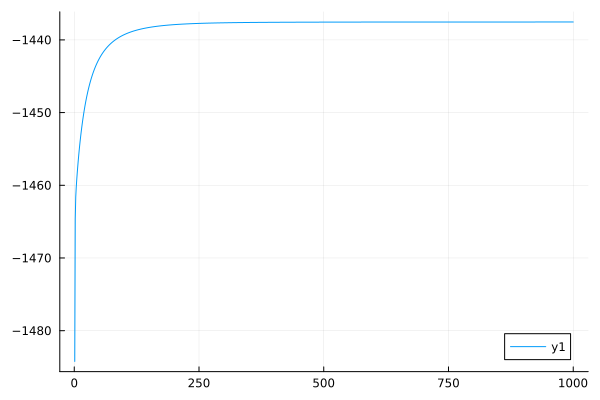

In [4]:
plot(lls)

In [17]:
x_sm, p_sm, inverse_offdiag = StateSpaceDynamics.smooth(lds, y)

([0.7484950076408544 0.7684036326059521 … -0.7135095548783905 -0.7303822842936367;;; 1.0874728100325903 1.0255012610248266 … -0.7823746984838222 -0.7188540100124853], [0.000434615967783968 0.006892110930868214 … 0.0370106540221214 0.04231149169892659;;; 0.00011766675469269975 0.0006078635196503969 … -0.006965075553844995 -0.009341254974928633;;;; 0.00011766675469269975 0.0006078635196503969 … -0.006965075553844995 -0.009341254974928633;;; 0.0004399668880339645 0.005055351215876685 … 0.03660204796957095 0.042106708444110935], [0.0 0.00036534632800312787 … 0.03125721965446936 0.03581686688833399;;; 0.0 7.701762219095183e-5 … -0.008003048186845003 -0.010313755793330118;;;; 0.0 0.00011644423984424041 … -0.004611462921564859 -0.006481757516415823;;; 0.0 0.0003807289871496345 … 0.03183824335738391 0.03657258449350604])

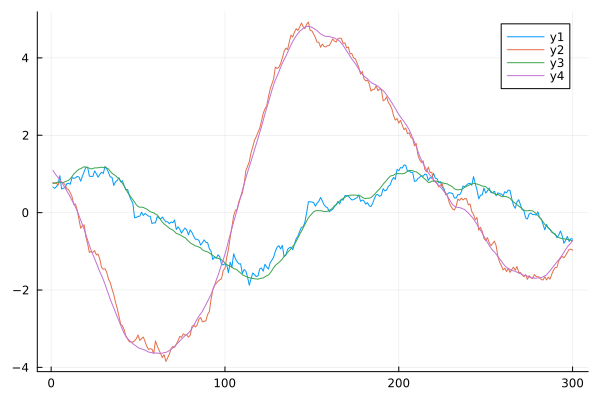

In [18]:
plot(x[1, :, :])
plot!(x_sm[1, :, :])

In [4]:
lls

100-element Vector{Float64}:
 768.4062923119811
 781.083988568942
 789.0598248352921
 796.3922809257813
 803.2394104678513
 809.6973268924569
 815.8258798813199
 821.6640687249474
 827.2395525406976
 832.573497705394
   ⋮
 976.7770020729281
 977.2636473898572
 977.7402522278014
 978.2070765569079
 978.6643720930164
 979.112382613175
 979.5513442571539
 979.9814858156607
 980.4030290058711

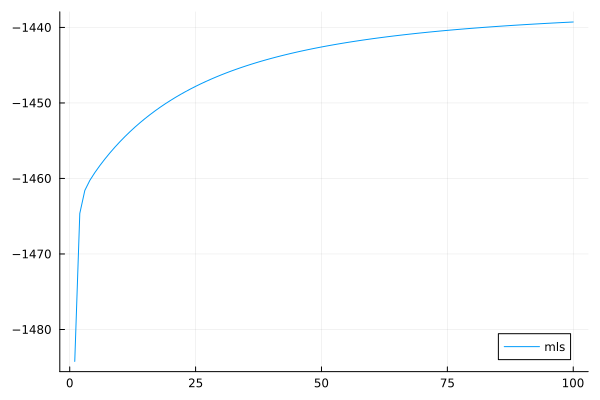

In [5]:
plot(lls, label="mls")

In [16]:
mls_filter = []
mls = []
mls_monte_carlo = []
for i in 1:100
    # get state params
    A, Q, x0, p0 = StateSpaceDynamics.stateparams(lds)
    # get obs params
    C, R = StateSpaceDynamics.obsparams(lds)

    lds_1 = StateSpaceDynamics.LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)
    # lds_2 = StateSpaceDynamics.LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)
    # lds_3 = StateSpaceDynamics.LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)
    # filter each series individually
    x_filt, p_filt, x_pred, p_pred, v, S, K, ml_1 = StateSpaceDynamics.KalmanFilter(lds_1, y[1, :, :])
    # x_filt, p_filt, x_pred, p_pred, v, S, K, ml_2 = StateSpaceDynamics.KalmanFilter(lds_2, y[2, :, :])
    # x_filt, p_filt, x_pred, p_pred, v, S, K, ml_3 = StateSpaceDynamics.KalmanFilter(lds_3, y[3, :, :])

    # calculate monte carlo estimates
    x_sm, p_sm, p_sm_1, ent = StateSpaceDynamics.smooth(lds, y)

    monte_carlo_estimate = sum([logpdf(MvNormal(lds.obs_model.C * x_sm[1, t, :], lds.obs_model.R), y[1, t, :]) for t in axes(y, 2)])

    push!(mls_monte_carlo, monte_carlo_estimate)
    
    lls, norms = fit!(lds, y, max_iter=1)

    push!(mls_filter, ml_1)
    push!(mls, lls)
end


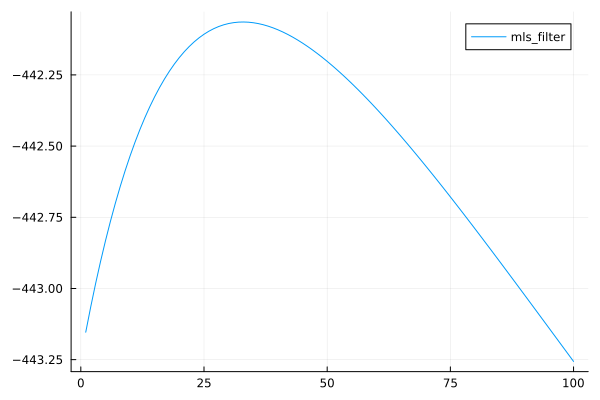

In [17]:
plot(mls_monte_carlo, label="mls_filter")

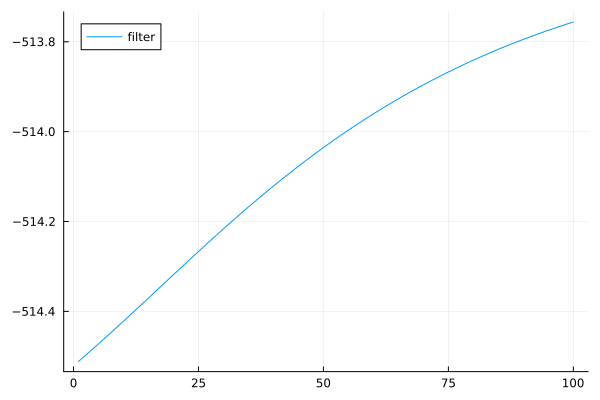

In [18]:
plot(mls_filter, label="filter")


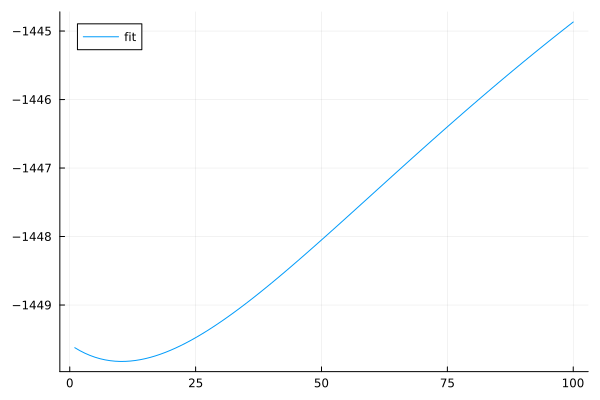

In [19]:
plot(vcat(mls...), label="fit")

In [5]:
# Function to run a single LDS fitting process
function run_single_lds()
    lds = StateSpaceDynamics.GaussianLDS(;A=A, C=C, Q=Q, R=R, x0=x0, P0=P0, obs_dim=2, latent_dim=2, fit_bool=[true, true, true, true, true, true])
    x, y = StateSpaceDynamics.sample(lds, 300, 1)
    new_lds = GaussianLDS(obs_dim=2, latent_dim=2)
    lls, norms = fit!(lds, y; max_iter=100)
    return lls, norms
end


# Run the process 20 times
n_runs = 10
all_lls = []
all_norms = []

for _ in 1:n_runs
    lls, norms = run_single_lds()
    push!(all_lls, lls)
    push!(all_norms, norms)
end

# Plotting
p1 = plot(xlabel="Iteration", ylabel="Log-likelihood", legend=false, title="Log-likelihood across runs")
p2 = plot(xlabel="Iteration", ylabel="Norm of parameter diffs", legend=false, title="Norm of parameter diffs across runs")

for i in 1:n_runs
    x = 1:length(all_lls[i])
    plot!(p1, x, all_lls[i], alpha=0.5, color=palette(:viridis, n_runs)[i])
    plot!(p2, x, all_norms[i], alpha=0.5, color=palette(:viridis, n_runs)[i])
end

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03
Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:03


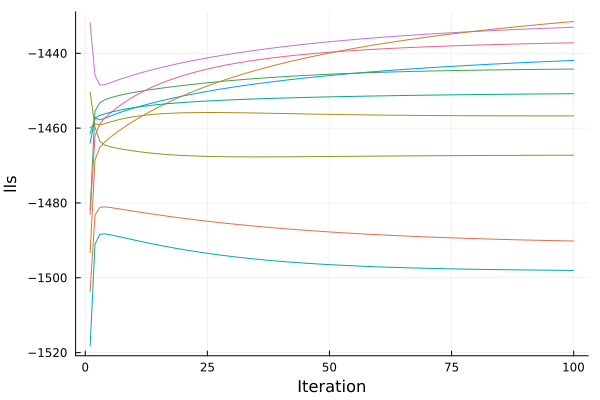

In [6]:
p = plot(xlabel="Iteration", ylabel="lls")
for i in 1:10
    plot!(p, 1:length(all_lls[i]), all_lls[i])
end
plot(p, legend=false)

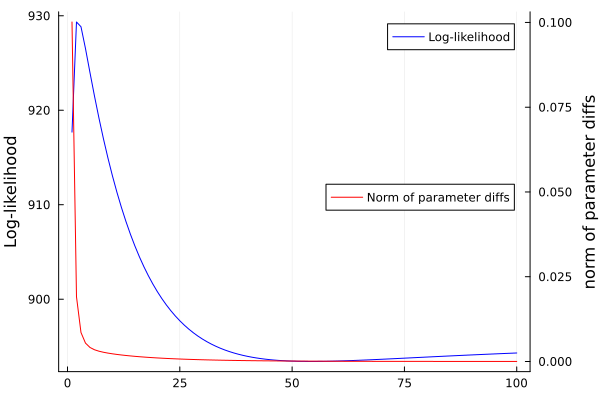

In [35]:
x = 1:1:length(lls)
plot(x, lls, color="blue", label="Log-likelihood", legend=:topright, ylabel="Log-likelihood")
plot!(twinx(), x, norms, color="red", label="Norm of parameter diffs", legend=:right, ylabel="norm of parameter diffs")

In [23]:
norms

100-element Vector{Float64}:
 0.1001333454749895
 0.019086558386312787
 0.00854509244952404
 0.005425745317556062
 0.004136963797383177
 0.0034614404326417957
 0.0030330325201783684
 0.0027210292429823276
 0.002472353205276309
 0.002262865355337728
 ⋮
 1.7997608243543555e-5
 1.7623142250465307e-5
 1.727139720558159e-5
 1.6940346607113135e-5
 1.6628142799304703e-5
 1.633310420630249e-5
 1.605370301334015e-5
 1.5788553184036605e-5
 1.553639909969476e-5

In [21]:
mls = []
qs =[]
entropies = []
for i in 1:100
    A, Q, x0, p0, C, R = lds.state_model.A, lds.state_model.Q, lds.state_model.x0, lds.state_model.P0, lds.obs_model.C, lds.obs_model.R
    E_z, E_zz, E_zz_prev, x_smooth, P_smooth, ml = StateSpaceDynamics.estep(lds, y)

    n_trials = size(E_z, 1)
    # calculate q
    ecll = 0.0
    for trial in 1:n_trials
        ecll += Q_val = StateSpaceDynamics.Q_function(
            A,
            Q,
            C,
            R,
            P0,
            x0,
            E_z[trial, :, :],
            E_zz[trial, :, :, :],
            E_zz_prev[trial, :, :, :],
            y[trial, :, :],
        )
    end
       
    entropy = 0.0
    for trial in 1:size(E_z, 1)
        for tStep in 1:size(E_z, 2)
            cov_matrix = P_smooth[trial, tStep, :, :] # Extract covariance matrix
            entropy += StateSpaceDynamics.gaussianentropy(cov_matrix)
        end
    end
    push!(mls, ml)
    push!(qs, ecll)
    push!(entropies, entropy)
    StateSpaceDynamics.mstep!(lds, E_z, E_zz, E_zz_prev, P_smooth, y)
end


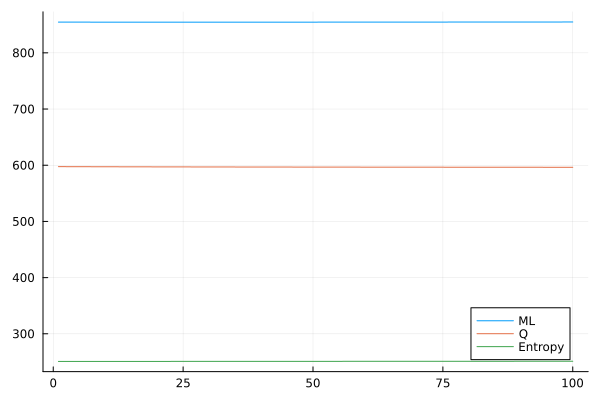

In [23]:
plot(mls, label="ML")
plot!(qs, label="Q")
plot!(-entropies, label="Entropy")

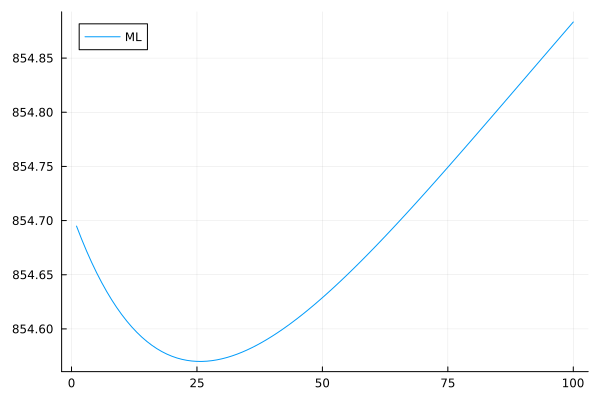

In [24]:
plot(mls, label="ML")

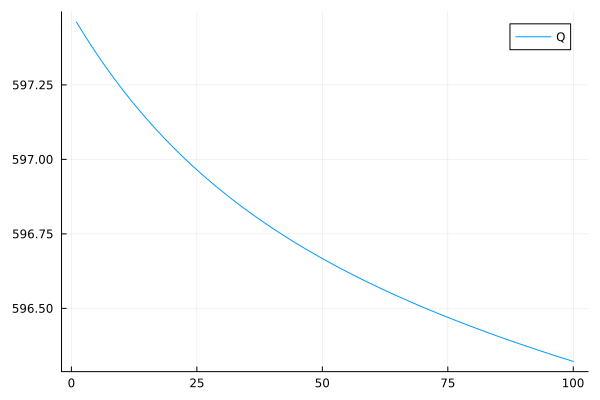

In [25]:
plot(qs, label="Q")

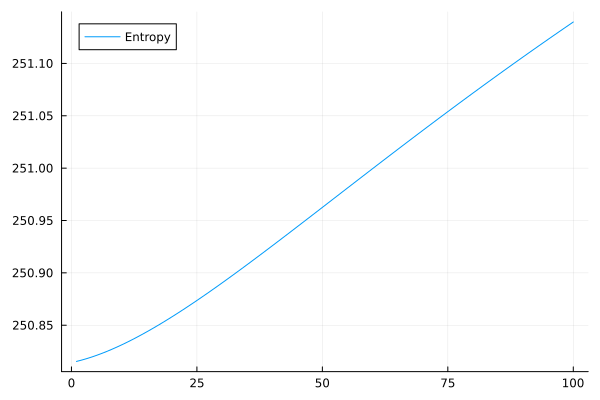

In [27]:
plot(-entropies, label="Entropy")

In [5]:
ls = fit!(lds, y, max_iter=1000)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:01:11


1000-element Vector{Float64}:
 290.20174487222965
 296.9559258591217
 299.02556402625214
 300.50816123707625
 301.653859960237
 302.61205031926136
 303.46631752398997
 304.26387970281894
 305.03202377850056
 305.7867744999036
   ⋮
 671.5493874844781
 671.632098127873
 671.7146940182379
 671.7971754530342
 671.8795427287473
 671.9617961402082
 672.0439359818754
 672.1259625464636
 672.20787612564

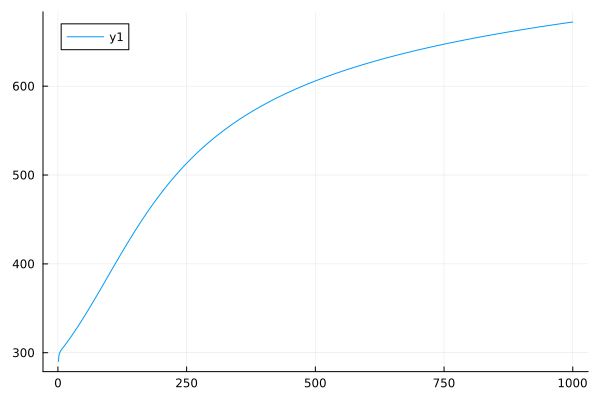

In [6]:
plot(ls)

In [18]:
all(diff(ls) .> 0)

false

In [92]:
E_z, E_zz, E_zz_prev, x_smooth, p_smooth, ml_total = SSM.estep(lds, y)

([-0.12707975276822361 -0.11729631582924951 … 0.3465653283138277 0.3386174371376877; 0.14454061101087512 0.21357414661475493 … -0.214415997348437 -0.277336393973309; -0.0477774007375271 -0.04908940404027147 … 1.037314341857955 1.0070498171224052;;; 1.311320757944344 1.3392750662499917 … -0.2581278105895398 -0.28096269403659824; 1.4295785540411698 1.4565996562607397 … -5.023868220692389 -5.003124717012324; 0.9049928716262414 0.8662675174547664 … -0.40190648580485505 -0.49191799775156564], [0.046123523320992815 0.04154556194451241 … 0.15747186439415659 0.1587348730281291; 0.05086624798875709 0.07340105233961819 … 0.08333855752381035 0.12098857971655166; 0.032256939778594236 0.030196905826426382 … 1.1133853814290875 1.0582224384607029;;; -0.16230598461934587 -0.15411734669068522 … -0.09440326703692621 -0.10272232961625824; 0.210968490789215 0.3140667130076457 … 1.0722525974738433 1.379965105384645; -0.03890187399223141 -0.039549871708887095 … -0.4218484794241395 -0.5029693919052189;;;; -0

In [61]:
x0_new = (E_z[1, 1, :] + E_z[2, 1, :] + E_z[3, 1, :]) ./ 3

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [87]:
function obj(x0::AbstractVector, P0_sqrt::AbstractMatrix, lds)
    A, Q = lds.state_model.A, lds.state_model.Q
    P0 = P0_sqrt * P0_sqrt'
    Q_val = 0.0
    for i in axes(E_z, 1)
        Q_val += SSM.Q_state(A, Q, P0, x0, E_z[i, :, :], E_zz[1, :, :, :], E_zz_prev[1, :, :, :])
    end
    return -Q_val
end

p0_init = Matrix(cholesky((p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3).U) .+ 1e-6

result = optimize(p0_sqrt -> obj(x0_new, p0_sqrt, lds), p0_init, LBFGS(), Optim.Options(g_tol=1e-12))

DomainError: DomainError with -1.0:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

In [94]:
fit!(lds, y, max_iter=1)

1-element Vector{Float64}:
 634.1856079992872

In [101]:
# optimize the A and Q entries using autograd
function obj(A::AbstractMatrix, Q_sqrt::AbstractMatrix, lds)
    Q = Q_sqrt * Q_sqrt'
    Q_val = 0.0
    for i in axes(E_z, 1)
        Q_val += SSM.Q_state(A, Q, lds.state_model.P0, lds.state_model.x0, E_z[i, :, :], E_zz[1, :, :, :], E_zz_prev[1, :, :, :])
    end
    return -Q_val
end

Q_sqrt = rand(2, 2)
result_a = optimize(A_new -> obj(A_new, Q_sqrt, lds), A, LBFGS(), Optim.Options(g_tol=1e-12))

f = A_new -> obj(A_new, Q_sqrt, lds)
ForwardDiff.gradient(f, lds.state_model.A)

2×2 Matrix{Float64}:
  2.15768   -3.15425
 -4.12196  -12.4146

In [103]:
result_a.minimizer

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [104]:
lds.state_model.A

2×2 Matrix{Float64}:
  0.993706  0.00769286
 -0.100821  1.00272

In [66]:
result.minimizer * result.minimizer'

2×2 Matrix{Float64}:
  0.294608  -1.37822
 -1.37822    6.44752

In [110]:
S01_1 = dropdims(sum(E_zz_prev[1, :, :, :], dims=1), dims=1)
S01_2 = dropdims(sum(E_zz_prev[2, :, :, :], dims=1), dims=1)
S01_3 = dropdims(sum(E_zz_prev[3, :, :, :], dims=1), dims=1)

S00_1 = dropdims(sum(E_zz[1, 1:end-1, :, :], dims=1), dims=1)
S00_2 = dropdims(sum(E_zz[2, 1:end-1, :, :], dims=1), dims=1)
S00_3 = dropdims(sum(E_zz[3, 1:end-1, :, :], dims=1), dims=1)

A_1 = S01_1 / S00_1
A_2 = S01_2 / S00_2
A_3 = S01_3 / S00_3

A_new = (A_1 + A_2 + A_3) ./ 3

2×2 Matrix{Float64}:
  0.979349  0.0167926
 -0.102614  1.00222

In [113]:
(S01_1 + S01_2 + S01_3) / (S00_1 + S00_2 + S00_3)

2×2 Matrix{Float64}:
  0.993706  0.00769286
 -0.100821  1.00272

In [112]:
ForwardDiff.gradient(f, A_new)

2×2 Matrix{Float64}:
  1.96989   -0.801541
 -4.9502   -14.7797

In [89]:
(p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3

2×2 Matrix{Float64}:
 0.0299743   0.00433633
 0.00433633  0.0323025

In [88]:
((E_zz[1, 1, :, :] - (x0_new * x0_new')) + (E_zz[2, 1, :, :] - (x0_new * x0_new')) + (E_zz[3, 1, :, :] - (x0_new * x0_new'))) ./ 3

2×2 Matrix{Float64}:
 0.0429801  0.0155347
 0.0155347  0.0827777

In [74]:
Matrix(cholesky((p_smooth[1, 1, :, :] + p_smooth[2, 1, :, :] + p_smooth[3, 1, :, :]) ./ 3).U)

Cholesky{Float64, Matrix{Float64}}
U factor:
2×2 UpperTriangular{Float64, Matrix{Float64}}:
 0.173131  0.0250466
  ⋅        0.177975

In [72]:
fit!(lds, y, max_iter=1)

1-element Vector{Float64}:
 634.1856079992872

In [73]:
lds.state_model.P0

2×2 Matrix{Float64}:
 0.0429801  0.0155347
 0.0155347  0.0827777

In [21]:
lds_old = LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)
KalmanFilterEM!(lds_old, y[1, :, :], 1)

lds_old.A

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [22]:
lds_old.R

2×2 Matrix{Float64}:
 0.30225    0.0106356
 0.0106356  0.224827

In [23]:
fit!(lds, y, max_iter=1, tol=1e-6)
lds.state_model.A

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

In [24]:
lds.obs_model.R

2×2 Matrix{Float64}:
 0.30225    0.0106356
 0.0106356  0.224827

In [16]:
dropdims(sum(E_zz_prev[1, :, :, :], dims=1), dims=1) / dropdims(sum(E_zz[1, 1:end-1, :, :], dims=1), dims=1)

2×2 Matrix{Float64}:
  0.939135  0.0300063
 -0.098745  1.00899

2×2 Matrix{Float64}:
 19.0395   23.3599
 23.3599  101.999

In [13]:
lds.state_model.x0

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [11]:
(x_smooth[1, 1, :] + x_smooth[2, 1, :] + x_smooth[3, 1, :]) ./ 3

2-element Vector{Float64}:
 -0.01010551416495853
  1.2152973945372516

In [87]:
mean([x_smooth[1, 1, :], x_smooth[2, 1, :], x_smooth[3, 1, :]])

2-element Vector{Float64}:
 -0.010105514164958584
  1.2152973945372534

In [33]:
lls = fit!(lds, y, max_iter=200, tol=1e-3)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:00:02


200-element Vector{Float64}:
 314.4993447458949
 315.1001767805533
 315.69908092830997
 316.29604835391433
 316.89107065239676
 317.4841398417627
 318.0752483556431
 318.66438903596463
 319.2515551256347
 319.8367402612281
   ⋮
 396.13059095037454
 396.4182983252392
 396.7049687780559
 396.990607843033
 397.27522102421
 397.5588137956746
 397.8413916014705
 398.1229598557544
 398.4035239427527

In [37]:
all(diff(lls) .> 0)

true

In [16]:
# write each y to a csv file
using CSV
using DataFrames

for i in 1:3
    CSV.write("/home/ryansenne/Desktop/data$i.csv", DataFrame(y[i, :, :], :auto))
end

In [15]:
y[1, :, :]

100×2 Matrix{Float64}:
 -0.323551    1.70326
  0.969088    1.44884
 -0.498399    1.78164
 -0.331751    1.01118
 -0.0652428   0.850834
 -1.03334     1.5051
 -0.315437    0.772258
 -0.167026    1.82909
  0.438854    1.52128
 -0.777171    1.10948
  ⋮          
  0.956269   -0.774274
  1.31636    -0.506619
  0.204983    0.285933
  0.374959   -0.613604
  0.422337    0.083254
  0.527896   -0.225842
  0.277655   -0.400379
 -0.0398075   0.0640761
  0.204452   -0.00188331

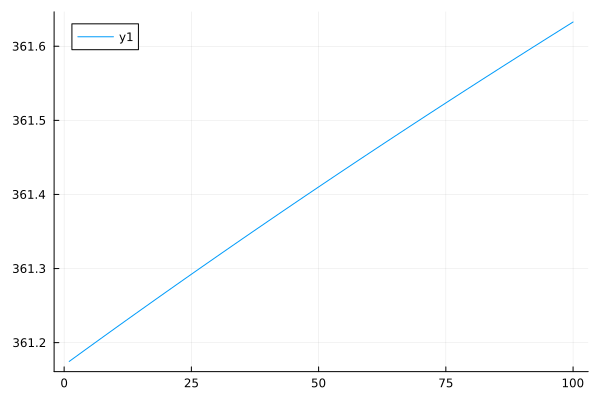

In [38]:
plot(lls)

In [18]:
lds.state_model.Q

2×2 Matrix{Float64}:
 0.0100715   0.00704897
 0.00704897  0.00493425

In [79]:
# test out the LDS model
lds_old = SSM.LDS(;A=A, H=C, Q=Q, R=R, x0=x0, p0=P0, obs_dim=2, latent_dim=2)

# KalmanFilterEM!(lds_old, y[1, :, :], 1, 1e-3, RTSSmoothing())

LDS([1.0 0.01; -0.0981 1.0], [1.0 0.0; 0.0 1.0], [0.0; 0.0;;], [0.01 0.0; 0.0 0.01], [0.25 0.0; 0.0 0.25], [0.0, 1.0], [0.1 0.0; 0.0 0.1], [0.0;;], 2, 2, Bool[1, 1, 1, 1, 1, 1, 1])

In [1]:
using CSV
using DataFrames
using StateSpaceDynamics

ddir = "/Users/ryansenne/Downloads/"

# Load Data
pl_n = CSV.read(joinpath(ddir, "recall_f5_pl_neurons.csv"), DataFrame)
pl_a = CSV.read(joinpath(ddir, "recall_f5_pl_astros.csv"), DataFrame)
vca1_n = CSV.read(joinpath(ddir, "recall_f5_vca1_neurons.csv"), DataFrame)
vca1_a = CSV.read(joinpath(ddir, "recall_f5_vca1_astros.csv"), DataFrame)


Row,Column1,0
,Int64,Float64
1,0,4.78786
2,1,2.3194
3,2,1.86246
4,3,1.8757
5,4,2.28806
6,5,1.65962
7,6,2.00542
8,7,1.8502
9,8,2.10316


In [3]:
data_matrix = cat(
    Matrix(pl_n[1:3:end, 2:end]),
    Matrix(pl_a[1:3:end, 2:end]),
    Matrix(vca1_n[1:3:end, 2:end]),
    Matrix(vca1_a[1:3:end, 2:end]),
    dims=2,
)

data_matrix = reshape(data_matrix, 1, size(data_matrix)...)

1×3940×4 Array{Float64, 3}:
[:, :, 1] =
 0.632397  1.22578  1.158  0.790471  …  -1.46772  -1.47786  -1.69929

[:, :, 2] =
 -0.262667  -0.277777  -0.408571  -0.122709  …  1.14384  0.584787  0.169098

[:, :, 3] =
 1.73955  2.24004  1.92768  1.60858  …  -0.319956  -0.181418  0.238679

[:, :, 4] =
 4.78786  1.8757  2.00542  2.03594  …  -0.458714  -0.851927  -0.506659

In [4]:
lds = StateSpaceDynamics.GaussianLDS(;obs_dim=4, latent_dim=3, fit_bool=[true, true, true, true, true, true])

lls = StateSpaceDynamics.fit!(lds, data_matrix, max_iter=50)

Fitting LDS via EM... 100%|██████████████████████████████| Time: 0:06:03


([-23435.26964974033, -11510.117469255336, -8466.823569348888, -4693.100873545391, -1107.6644257855496, 1882.5610528185825, 4276.292369187143, 6135.995976605346, 7548.915688814839, 8620.433220800476  …  18512.582273738695, 18573.116158889254, 18629.144643202635, 18681.26797921092, 18729.94846188867, 18775.551249663054, 18818.372345815704, 18858.65778788577, 18896.616839544113, 18932.431099282672], [3.9985303824979708, 0.6117621180020643, 0.5344212637033943, 0.3289915128862243, 0.1616823556851812, 0.0849662292040698, 0.05168780729584958, 0.03699307505886822, 0.029846313434383716, 0.02561449656631608  …  0.00668590403499973, 0.006489048690762295, 0.00622195142330294, 0.005915026222241156, 0.005589719771544879, 0.0052606424026704485, 0.004937441106692017, 0.004626255040759126, 0.004330788249844864, 0.004053078607677814])

In [5]:
x_sm, p_sm, inverse_offdiag = StateSpaceDynamics.smooth(lds, data_matrix)

([-0.6245652865446176 0.23989734468485005 … 0.020409342681313954 -0.1919976822771172;;; 1.5600518096136389 1.6100883620422157 … -1.2084612438502362 -1.0841330813292303;;; -1.1049523528440917 -0.2184187970200665 … -0.26791640827574364 -0.07135399684704655], [0.005895257224289659 0.0409147635263925 … 0.04736214307034326 0.0717815491993591;;; -0.004027518125256526 -0.029152815937166846 … -0.03319922511195446 -0.05270742532780416;;; 0.004746148466680783 0.031797839094462876 … 0.03691658428283816 0.05704814742481361;;;; -0.004027518125256526 -0.029152815937166846 … -0.03319922511195446 -0.05270742532780416;;; 0.00282974300605235 0.022659456158861425 … 0.025280824733353302 0.04088575674402112;;; -0.0032692185899283457 -0.02345804871424191 … -0.026701137969637873 -0.042880301326300566;;;; 0.004746148466680783 0.031797839094462876 … 0.03691658428283816 0.05704814742481361;;; -0.0032692185899283457 -0.02345804871424191 … -0.026701137969637873 -0.042880301326300566;;; 0.003915972191441354 0.0273

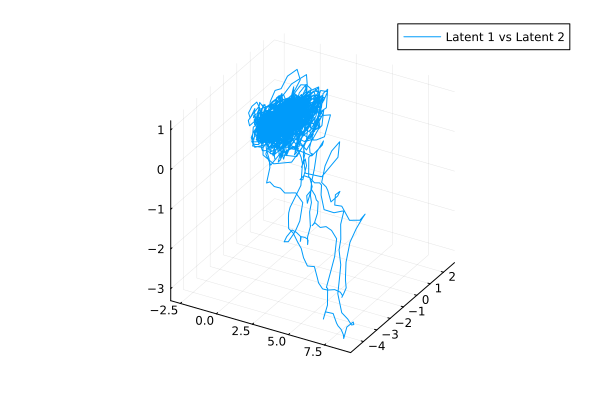

In [12]:
using Plots
plot(x_sm[1, :, 1], x_sm[1, :, 2], x_sm[1, :, 3], label="Latent 1 vs Latent 2")

In [15]:
y_pred = lds.obs_model.C * x_sm[1, :, :]'

4×3940 Matrix{Float64}:
 0.973911    1.51539     1.35443   …  -1.05919   -1.03221   -1.04099
 0.263898   -0.0842527  -0.202664      1.00995    0.564181   0.238482
 0.837372    1.51279     1.46187      -1.06769   -1.06119   -1.06215
 0.0278942   0.0842458   0.178276      0.514269   0.206142   0.0161703

In [30]:
# # plot(y_pred[1, :])
# # plot!(data_matrix[1, :, 1])

# # plot(y_pred[2, :])
# # plot!(data_matrix[1, :, 2])

# plot(y_pred[3, :])
# plot!(data_matrix[1, :, 3])

# plot(y_pred[4, :])
# plot!(data_matrix[1, :, 4])